In [78]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import dctn, idctn, dct, idct
from scipy.interpolate import interp1d

from tqdm import tqdm

from typing import Union

# The Back-and-Forth Algorithm

Let our $\Omega \subset \R^d$ be a convex and compact region. Consider a cost function of a form
$$ c(x, y) = h(y-x) $$
where function $h : \R^d \to \R$ is strictly convex and even function.

The optimal transport problem is being stated in it's dual form:
$$ C(\mu, \nu) = \sup_{\varphi : \Omega \to \R} \int_{\Omega} \varphi(y) \nu(y) dy + \int_{\Omega} (\varphi)^{c} (x) \mu(x) dx $$
for two measures $\mu$ and $\nu$ and continuous functions $\varphi: \Omega \to \R$.

The operation $(\cdot)^{c}$ is called __c-transform__ and is being defined as:
$$ \varphi^{c}(x) = \inf_{y \in \Omega} \left\{ c(x,y) - \varphi(y) \right\} $$

Also we define two functionals $J: \mathcal{H} \to \R$ and $I: \mathcal{H} \to \R$
$$ J(\varphi) = \int_{\Omega} \varphi d \nu + \int_{\Omega} \varphi^{c} d \mu $$
$$ I(\psi) = \int_{\Omega} \psi^{c} d \nu + \int_{\Omega} \psi d \mu $$

And our operating Hilbert space will be
$$ \dot{H}^1 = \left\{ \varphi : \Omega \to \R : \int_{\Omega} \varphi dx = 0 \text{ and } \nabla \varphi \in L^2 (\Omega) \right\} $$

We get the following update scheme
$$
\begin{align}
\varphi_{n+1/2} &= \varphi_{n} + \sigma \nabla_{\dot{H}^1} J(\varphi_{n}) \\
\psi_{n+1/2}    &= (\varphi_{n+1/2})^{c} \\
\psi_{n+1}    &= \psi_{n} + \sigma \nabla_{\dot{H}^1} I(\psi_{n}) \\
\varphi_{n+1}   &= (\psi_{n+1})^{c}
\end{align}
$$

where the functionals $J(\varphi_n)$ and $I(\psi_n)$ are defined as:
$$ J(\varphi) = \int_{\Omega} \varphi d \nu + \int_{\Omega} (\varphi)^{c} d \mu $$
$$ I(\psi) = \int_{\Omega} (\psi)^{c} d \nu + \int_{\Omega} \psi d \mu $$
over the space of continuous functions $\varphi : \Omega \to \R$ and $\psi : \Omega \to \R$.

How do we compute $\nabla_{\dot{H}^1} J(\varphi_n)$ or $\nabla_{\dot{H}^1} I(\psi_n)$?

By Lemma 3, we get that if $\varphi$ is c-concave, the first variation of $J$ can be expressed as
$$ \delta J_{\varphi} = \nu - T_{\varphi \#} \mu $$
and if $\psi$ is c-concave, the first variation of $I$ can be expressed as
$$ \delta I_{\psi} = \mu - T_{\psi \#} \nu $$

**some math .....**

At the end, we get
$$ \nabla_{\dot{H}^1} J(\varphi) = (-\Delta)^{-1} (\nu - T_{\varphi \#} \mu) $$
$$ \nabla_{\dot{H}^1} I(\psi) = (-\Delta)^{-1} (\mu - T_{\psi \#} \nu) $$

Here $(\Delta)^{-1}$ is the inverse Laplace operator which we get while solving this PDE:
$$
\begin{cases}
    - \Delta \varphi &= f \\
    \nabla \varphi &= 0 \quad \text{ on } \partial \Omega \quad \text{ (Neumann Boundary Condition) }
\end{cases}
$$

So here the function $f$ is equal to either $\nu - T_{\varphi \#} \mu$ or $\mu - T_{\psi \#} \nu$.



<!-- $$
    \rho_n = T_{\varphi_n \#} \mu  \qquad  \rho_{n+1/2} = T_{\varphi_{n+1/2} \#} \mu
$$ -->

### C-Transform and Pushforward

Let's remind ourselfes what c-transform of a function $\varphi$ is:

$$ \varphi^{c}(x) = \inf_{y \in \Omega} \left\{ c(x,y) - \varphi(y) \right\} $$

In [35]:
def _direct_c_transform(phi: np.ndarray, cost: np.ndarray) -> np.ndarray:
    """
    Perform a direct c-transform operation on the given cost matrix adjusted by vector phi.

    This function calculates the c-transform of a cost matrix and a vector phi.
    It computes the minimum value across rows of the element-wise subtraction between
    cost matrix and phi vector, treating phi as a bias.

    Parameters:
    - phi (np.ndarray): A vector that represents potential values.
    - cost (np.ndarray): A cost matrix.

    Returns:
    - np.ndarray: The transformed vector resulting from the direct c-transform computation.
    """
    # Direct computation with numpy
    # min_axis = int(phi.shape[0] == 1)
    # We set the direction of summation to 0 for phi case
    # for psi case we have to just transpose the cost matrix to be valid
    # min_axis = 0
    transform = (cost - phi).min(axis=1)
    # transform = (cost - phi).min(axis=min_axis)
    # transform_2d = np.tile(transform, (cost.shape[min_axis], 1))
    # return transform_2d
    return transform
    # return np.expand_dims(transform, axis=min_axis)

def ctransform(phi: np.ndarray, cost: Union[np.ndarray, str]) -> np.ndarray:
    """
    Computes the c-transform of a vector phi with respect to a cost matrix or handles
    alternative string-based methods (not implemented).

    Parameters:
    - phi (np.ndarray): A vector representing potential values.
    - cost (Union[np.ndarray, str]): Either a numpy array representing the cost matrix or a
      string indicating the method to be used for an optimized c-transform.

    Returns:
    - np.ndarray: The result of the c-transform calculation.

    Raises:
    - NotImplementedError: If the cost is specified as a string indicating an unimplemented method.
    - TypeError: If the cost parameter is neither a numpy array nor a string.
    """
    if isinstance(cost, np.ndarray):
        return _direct_c_transform(phi, cost)
    elif isinstance(cost, str):
        raise NotImplementedError('optimized ctransform has not been implemented')
    else:
        raise TypeError('cost must be either a numpy array or a string')

In [36]:
n, m = 3, 3
# x = np.linspace(0, 1, n).reshape((n, 1))
x = np.linspace(0, 1, n)
# y = np.linspace(0, 1, m).reshape((1, m))
y = np.linspace(0, 1, m)
X, Y = np.meshgrid(x, y, indexing='ij')

# phi = np.zeros((1, m))
# phi = np.power(np.linspace(0, 1, n), 2).reshape((n, 1))
phi = y ** 2
print(f"{phi.shape=}")
print(phi)
print()

cost = np.power(X - Y, 2) / 2
print(f"{cost.shape=}")
print(cost)
print()

transform = ctransform(phi, cost=cost)
print(f"{transform.shape=}")
transform

phi.shape=(3,)
[0.   0.25 1.  ]

cost.shape=(3, 3)
[[0.    0.125 0.5  ]
 [0.125 0.    0.125]
 [0.5   0.125 0.   ]]

transform.shape=(3,)


array([-0.5  , -0.875, -1.   ])

In [37]:
# psi = (np.linspace(0, 1, m) ** 2).reshape((1, m))
psi = x ** 2
# psi = np.linspace(0, 1, n)
print(f"{psi.shape=}")
print(psi)
print()

transform = ctransform(psi, cost=cost.T)
print(f"{transform.shape=}")
transform

psi.shape=(3,)
[0.   0.25 1.  ]

transform.shape=(3,)


array([-0.5  , -0.875, -1.   ])

The map $T$ is defined as $x$ minus the inverse gradient 
of $h$ applied to gradient of the potential for potential $\varphi$:
$$ T_{\varphi}(x) = x - (\nabla h)^{-1} ( \nabla \varphi^{c}(x) ) $$
$$ T_{\psi}(y) = y - (\nabla h)^{-1} ( \nabla \psi^{c}(y) ) $$

Then the pushforward of a measure $\mu$ for a set $A$:
$$ T_{\#}\mu (A) = \mu ( T^{-1} (A) ) $$

Let's test this on a discretized space which is a subspace of $\Omega = [0,1]$
$$
X = \{ x_1, x_2, \dots, x_n \} \subset \Omega
\qquad
Y = \{ y_1, y_2, \dots, y_m \} \subset \Omega
$$

We will use the meshgrids in the code (keep as close to the implementation as we can):
$$ \mathcal{X} = \left[ x_{ij} = x_i \in X \;\; \forall j = \overline{1,m} \;\; \forall i \in \overline{1, n} \right]_{n \times m} $$
$$ \mathcal{Y} = \left[ y_{ij} = y_j \in Y \;\; \forall i = \overline{1,n} \;\; \forall i \in \overline{1, m} \right]_{m \times n} $$

The gradient of $\varphi^{c}(\mathcal{X})$ we compute as
$$ \nabla \varphi^{c} (\mathcal{X}) = \left[ \nabla \varphi^{c} (x_{ij}) \right]_{n \times m} $$

Note that this gradient is repeated by columns, meaning that $\nabla \varphi^{c}(x_{ij}) = \nabla \varphi^{c}(x_i)$.

Basically, we should find such $\gamma = \left[ \gamma_{ij} \in \Omega \right]$ that
$$ (\nabla h)(\gamma) = \nabla \varphi^{c} (\mathcal{X}) $$
and this matrix $\gamma$ is found as
$$ \gamma = (\nabla h)^{-1}(\nabla \varphi^{c} (\mathcal{X})) $$

The problem we need to solve to find $\gamma$ is follow:

Find $\gamma = \left[ \gamma_{ij} \in \Omega \right]$ such that
$$ (\nabla h) (\gamma) = B $$
where $B$ is the computed gradient $\nabla \varphi^{c} (\mathcal{X})$.
<!-- $$ (\nabla h)(\gamma) = \nabla \varphi (\mathcal{X}) $$ -->

The ways to solve this equation:
1. Treat the equation like a PDE and use **Numerical solvers for PDEs**: finite difference methods, finite element methods, spectral methods.
2. **Matrix decomposition and Inverse methods**, which requires the matrix $(\nabla h)$ to be invertible.
3. **Iterative methods**: set the function to minimize $(\nabla h) - B$ and perform fi **gradient descent**.
4. **Regularization techniques**

For quadratic cost the pushforward operation is simplified to:
$$ T_{\varphi} (x) = x - \nabla \varphi^{c} (x) $$
$$ T_{\psi} (y) = y - \nabla \psi^{c} (y) $$

Since
$$ h(y-x) = \frac{1}{2} (y-x)^2 \; \implies \; \nabla h(y-x) = y-x
\; \implies \; (\nabla h)(\nabla \varphi^{c} (x)) = \nabla \varphi^{c} (x)  $$

In [153]:
def _map_T_quadratic_cost(phi: np.ndarray, X: np.ndarray, Y: np.ndarray, axis: int, C: np.ndarray) -> np.ndarray:
    # Note: currently, this works only for quadratic cost with given matrix C
    # this is due to unfinished ctransform function
    # return X - np.gradient(
    #     ctransform(phi, cost=C),
    #     axis=axis)
    # return X - np.gradient(
    #     ctransform(phi, cost=C))
    dx = max(X[1, 0] - X[0, 0], X[0, 1] - X[0, 0])
    # print('gradient inside')
    # print(np.gradient(
    #     ctransform(phi, cost=C),
    #     dx,  # data is evenly spaced. TODO: change later to a better way?
    # ))
    # print(ctransform(phi, cost=C).dtype)
    # print('and dx was', dx)
    # ct = ctransform(phi, cost=C)
    # print((ct[0] - ct[2]) / (2 * dx))
    return np.gradient(
        ctransform(phi, cost=C),
        dx,  # data is evenly spaced. TODO: change later to a better way?
    )

def map_T(phi: np.ndarray, cost: Union[np.ndarray, str], X: np.ndarray, Y: np.ndarray, axis: int, C: np.ndarray=None) -> np.ndarray:
    """Calculates the map T of a function phi given a cost type, using domains X and Y."""
    
    # Handling string type cost function
    if isinstance(cost, str):
        if cost == 'quadratic':
            return _map_T_quadratic_cost(phi, X, Y, axis, C)
        else:
            raise NotImplementedError(f"Not implemented for cost type '{cost}'")
    
    # Handling numpy array type cost function (currently not implemented)
    elif isinstance(cost, np.ndarray):
        raise NotImplementedError("Matrix cost types are not implemented")
    
    # Handling invalid cost type
    else:
        raise TypeError("Cost must be either a string or a numpy array")

In [152]:
def sampling_pushforward_1d(mu, xMap, xs):
    rho = np.zeros_like(mu)
    n = xs.shape[0]

    # print('x')
    # print(xs)
    # print('xMap')
    # print(xMap)
    
    for j in range(n):
        mass = mu[j]
        if mass > 0:
            xStretch = abs(xMap[min(j + 1, n - 1)] - xMap[j])
            xSamples = max(int(n * xStretch), 1)
            factor = 1.0 / xSamples

            for k in range(xSamples):
                a = (k + 0.5) / xSamples
                xPoint = (1 - a) * xMap[j] + a * xMap[min(j + 1, n - 1)]
                X = xPoint * n - 0.5

                xIndex = int(X)
                xFrac = X - xIndex

                # Boundary conditions
                xIndex = min(max(xIndex, 0), n - 1)
                xOther = min(max(xIndex + 1, 0), n - 1)

                # Distribute mass to the nearest indices
                rho[xIndex] += (1 - xFrac) * mass * factor
                rho[xOther] += xFrac * mass * factor

    # Normalize the resulting density to maintain total mass
    rho /= np.sum(rho)

    return rho


def pushforward(mu: np.ndarray, T: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Transforms the measure mu using the multidimensional transport map T.
    
    :param mu: numpy array representing the original measure (discrete densities or probabilities)
    :param T: numpy array where each row represents the new multidimensional position of each corresponding element in mu
    :return: numpy array of the transformed measure
    """
    # nu = T.T @ mu
    # nu /= nu.sum()
    nu = sampling_pushforward_1d(mu, T, x)
    return nu

[0.05555556 0.08333333 0.13888889 0.22222222 0.30555556 0.36111111
 0.44444444 0.52777778 0.58333333 0.61111111]


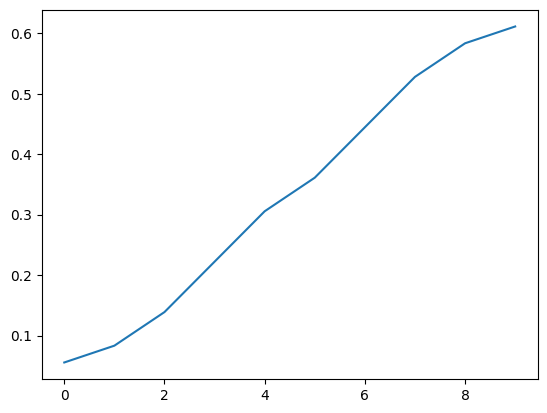

In [111]:
def generate_gaussian_distribution(
        num_points, mean, std, range_min, range_max
):
    grid = np.linspace(range_min, range_max, num_points)
    pdf_values = 1/(std * np.sqrt(2 * np.pi)) * np.exp(
        -1/2 * np.power((grid - mean)/std, 2))
    pdf_values /= pdf_values.sum()
    return grid, pdf_values

n = 10
std = 0.08
range_min = 0
range_max = 1

x = np.linspace(range_min, range_max, n)
y = np.linspace(range_min, range_max, n)
X, Y = np.meshgrid(x, y, indexing='ij')

grid1, pdf1 = generate_gaussian_distribution(n, 0.2, std, range_min, range_max)
grid2, pdf2 = generate_gaussian_distribution(n, 0.6, std, range_min, range_max)

c = np.power(X - Y, 2) / 2
c_name = 'quadratic'

phi = -y ** 2
# phi = np.zeros_like(y)

T = map_T(phi, c_name, X, Y, 1, c)

print(T)

# p = plt.imshow(T)
p = plt.plot(T)
# plt.colorbar(p)

# pf = pushforward(pdf1, T)
# print(f"{pf.sum()=}")
# plt.scatter(x, pf)

In [112]:
pushforward(pdf1, T, x)

array([1.35877829e-01, 5.57750227e-01, 2.82812628e-01, 2.35442682e-02,
       1.50395150e-05, 8.17386044e-09, 1.45202930e-13, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

### Gradient and PDE

Let's remind ourselfes the formula to get the gradient:
$$ \nabla_{\dot{H}^1} J(\varphi) = (-\Delta)^{-1} (\nu - T_{\varphi \#} \mu) $$
$$ \nabla_{\dot{H}^1} I(\psi) = (-\Delta)^{-1} (\mu - T_{\psi \#} \nu) $$

Here $(\Delta)^{-1}$ is the inverse Laplace operator which we get while solving this PDE:
$$
\begin{cases}
    - \Delta \varphi &= f \\
    \nabla \varphi &= 0 \quad \text{ on } \partial \Omega \quad \text{ (Neumann Boundary Condition) }
\end{cases}
$$

So here the function $f$ is equal to either $\nu - T_{\varphi \#} \mu$ or $\mu - T_{\psi \#} \nu$.

In [42]:
# def gradient(nu, t_mu):
#     f = nu - t_mu
#     n, m = t_mu.shape
#     phi = solve_pde(f, n ,m)
#     return phi


# def solve_pde(f: np.ndarray, n: int, m: int):
#     # TODO: any faster way to solve pde?
#     # for now we solve this poisson pde with cosine transform (FFT)
#     x, y = np.meshgrid(
#         np.linspace(0, np.pi, n, False),
#         np.linspace(0, np.pi, m, False)
#     )
#     kernel = 2 * n**2 * (1 - np.cos(x)) + 2 * m**2 * (1 - np.cos(y))
#     kernel[0, 0] = 1  # to avoid deviding by zero??

#     wsp = dctn(f, norm='ortho')
#     wsp /= kernel
#     wsp[0, 0] = 0
#     wsp = idctn(wsp, norm='ortho')

#     return wsp

In [95]:
def solve_pde(f, L, N):
    """
    Solves the Poisson equation -∆phi = f with Neumann boundary conditions
    using the Discrete Cosine Transform.

    Parameters:
    f : ndarray
        The source term of the Poisson equation.
    L : float
        The length of the domain.
    N : int
        The number of discretization points.

    Returns:
    x : ndarray
        The discretized domain.
    phi : ndarray
        The solution of the Poisson equation.
    """
    # Compute the discrete cosine transform of f
    f_hat = dct(f, norm='ortho')
    # Create an array of wave numbers (avoid division by zero for k=0)
    k = np.pi * np.arange(N) / L
    k[0] = 1  # avoid division by zero; will set phi_hat[0] to zero later
    # Compute the solution in the spectral domain
    phi_hat = f_hat / (k**2)
    # Set the zero-frequency component to zero
    phi_hat[0] = 0
    # Compute the inverse discrete cosine transform to get the spatial solution
    phi = idct(phi_hat, norm='ortho')
    return phi

In [96]:
def gradient(nu: np.ndarray, t_mu: np.ndarray, x: np.ndarray):
    f = nu - t_mu
    L = x[-1]
    phi = solve_pde(f, L, x.size)
    return phi

In [103]:
def generate_gaussian_distribution(
        num_points, mean, std, range_min, range_max
):
    grid = np.linspace(range_min, range_max, num_points)
    pdf_values = 1/(std * np.sqrt(2 * np.pi)) * np.exp(
        -1/2 * np.power((grid - mean)/std, 2))
    pdf_values /= pdf_values.sum()
    return grid, pdf_values

n = 10
std = 0.08
range_min = 0
range_max = 1

x = np.linspace(range_min, range_max, n)
y = np.linspace(range_min, range_max, n)
X, Y = np.meshgrid(x, y, indexing='ij')

grid1, pdf1 = generate_gaussian_distribution(n, 0.2, std, range_min, range_max)
grid2, pdf2 = generate_gaussian_distribution(n, 0.6, std, range_min, range_max)

c = np.power(X - Y, 2) / 2
c_name = 'quadratic'

phi = -y ** 2

rho = pushforward(
    pdf1,
    map_T(phi, c_name, X, Y, axis=0, C=c),
)
print(
    pdf1,
    map_T(phi, c_name, X, Y, axis=0, C=c),
)

print(f"{rho.shape=}")
print(f"{pdf2.shape=}")

g = gradient(pdf2, rho, y)
g

[2.43513484e-02 2.98958053e-01 5.33258863e-01 1.38199506e-01
 5.20373870e-03 2.84685308e-05 2.26284710e-08 2.61328003e-12
 4.38487554e-17 1.06897900e-22] [0.05555556 0.08333333 0.13888889 0.22222222 0.30555556 0.36111111
 0.44444444 0.52777778 0.58333333 0.61111111]
rho.shape=()
pdf2.shape=(10,)


array([-0.00787633, -0.00687748, -0.00487472, -0.001881  ,  0.00205807,
        0.0058167 ,  0.00629805,  0.00409465,  0.00211942,  0.00112263])

In [ ]:
psi = -x ** 2

rho = pushforward(
    pdf2,
    map_T(psi, c_name, Y, X, axis=1, C=c.T),
)
print(f"{rho.shape=}")
print(f"{pdf1.shape=}")

g = gradient(pdf1, rho, x)
g

In [154]:
def plot_potentials(phi, psi):
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    im1 = axs[0].imshow(phi, aspect='auto')
    axs[0].set_title('$\phi$')
    fig.colorbar(im1, ax=axs[0])
    im2 = axs[1].imshow(psi, aspect='auto')
    axs[1].set_title('$\psi$')
    fig.colorbar(im2, ax=axs[1])
    plt.tight_layout()
    plt.show()


def back_and_forth(
        x: np.ndarray,
        y: np.ndarray,
        mu: np.ndarray,
        nu: np.ndarray,
        cost: np.ndarray,
        cost_name: str,
        sigma: float = 0.01,
        iterations: int = 20,
        ):
    phi = np.zeros_like(x)
    psi = np.zeros_like(y)

    X, Y = np.meshgrid(x, y, indexing='ij')

    # why do we really need rho here?
    rho = np.copy(mu)
    # print(f"{rho.shape=}")
    
    history = np.empty(nu[np.newaxis, :].shape)

    for i in tqdm(range(iterations)):
        # print(f"iteration {i}")
        # what is rho1 and rho2 here?
        # print(pushforward(phi, cost_name, X, Y, axis=1, C=cost))
        phi_grad = gradient(
            nu,
            # Note: for now pushforward is only implemented for quadratic cost
            # pushforward(phi, cost_name, X, Y, axis=1, C=cost),
            rho,
            x,
            )
        # print(f"{phi.shape=}")
        # print(f"{psi.shape=}")
        # print(f"{phi_grad.shape=}")
        # print(phi_grad)
        phi += sigma * phi_grad
        psi = ctransform(phi, cost)

        rho = pushforward(
            mu,
            map_T(phi, cost_name, X, Y, axis=1, C=cost),
            y
        )
        # print('rho with T_phi#mu')
        # print(rho)
        # print('map T_phi')
        # print(map_T(phi, cost_name, X, Y, axis=1, C=cost))

        psi_grad = gradient(
            mu,
            # Note: for now pushforward is only implemented for quadratic cost
            # pushforward(psi, cost_name, Y, X, axis=0, C=cost.T),
            rho,
            y,
            )
        psi += sigma * psi_grad
        phi = ctransform(psi, cost.T)

        # print('psi after grad')
        # print(psi)
        # print(ctransform(psi, cost=cost.T))
        # print(map_T(psi, cost_name, Y, X, axis=0, C=cost.T))

        # rho = pushforward(psi, cost_name, Y, X, axis=0, C=cost.T)
        rho = pushforward(
            nu,
            map_T(psi, cost_name, Y, X, axis=0, C=cost.T),
            x
        )

        # history = np.append(history, rho)


        # mt_phi = map_T(phi, cost_name, X, Y, axis=1, C=cost)
        # mt_psi = map_T(psi, cost_name, Y, X, axis=0, C=cost.T)
        # fig, axs = plt.subplots(1, 4)
        # axs[0].scatter(x, mu)
        # axs[1].scatter(y, rho)
        # axs[2].imshow(mt_phi)
        # axs[3].imshow(mt_psi)

    return phi, psi, history

# 1-D Examples

In [117]:
def generate_gaussian_distribution(
        num_points, mean, std, range_min, range_max
):
    grid = np.linspace(range_min, range_max, num_points)
    pdf_values = 1/(std * np.sqrt(2 * np.pi)) * np.exp(
        -1/2 * np.power((grid - mean)/std, 2))
    pdf_values /= pdf_values.sum()
    return grid, pdf_values

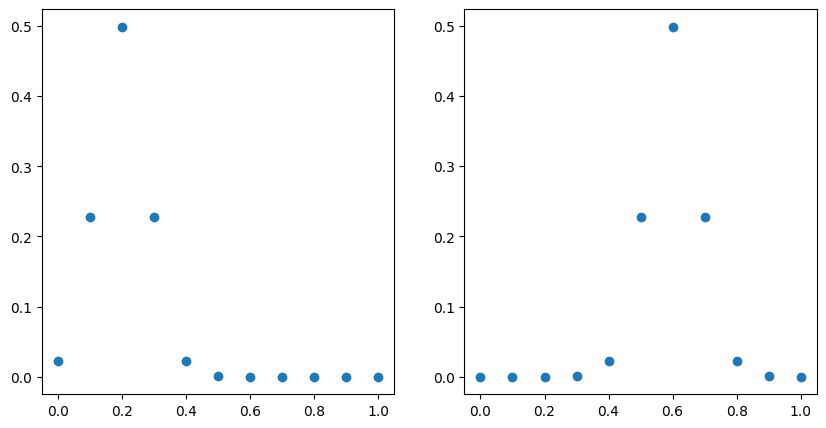

In [125]:
n = 11
# n = 100 + 1   # Number of points
std = 0.08
range_min = 0
range_max = 1

x = np.linspace(range_min, range_max, n)
y = np.linspace(range_min, range_max, n)
X, Y = np.meshgrid(x, y, indexing='ij')

grid1, pdf1 = generate_gaussian_distribution(n, 0.2, std, range_min, range_max)
grid2, pdf2 = generate_gaussian_distribution(n, 0.6, std, range_min, range_max)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].scatter(grid1, pdf1)
axs[1].scatter(grid2, pdf2)
# fig.show()

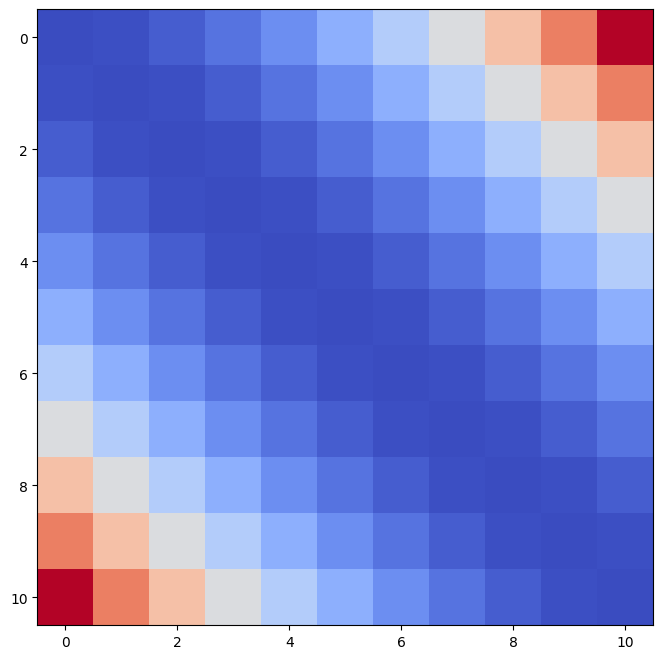

In [126]:
c = np.power(X - Y, 2) / 2
c_name = 'quadratic'


fig, axs = plt.subplots(1, 1, figsize=(10,8))
axs.imshow(c, cmap='coolwarm')

In [184]:
%time

phi, psi, history = back_and_forth(x, y, pdf1, pdf2, c, c_name, sigma=0.001, iterations=200_000)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


100%|██████████| 200000/200000 [01:02<00:00, 3178.00it/s]


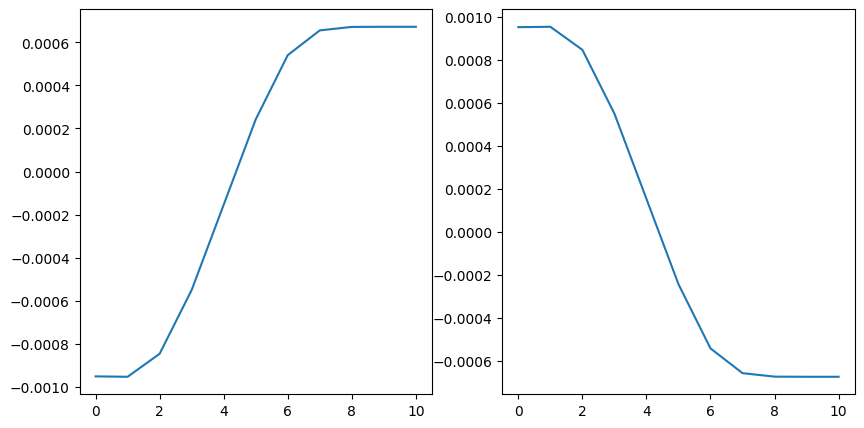

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(phi)
axs[1].plot(psi)

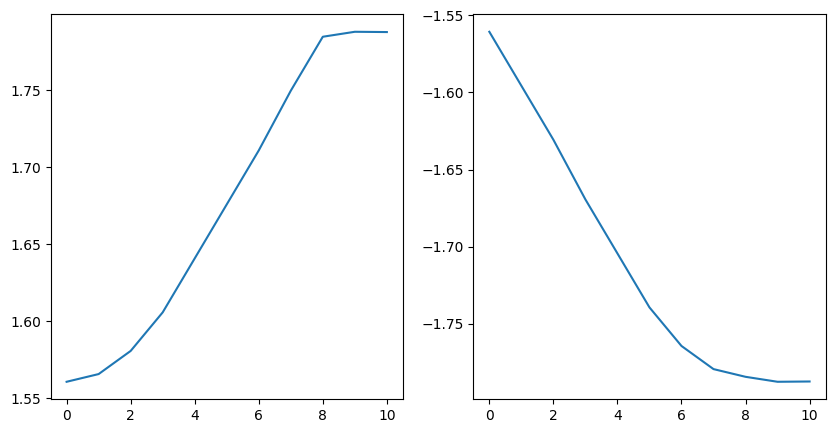

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(phi)
axs[1].plot(psi)

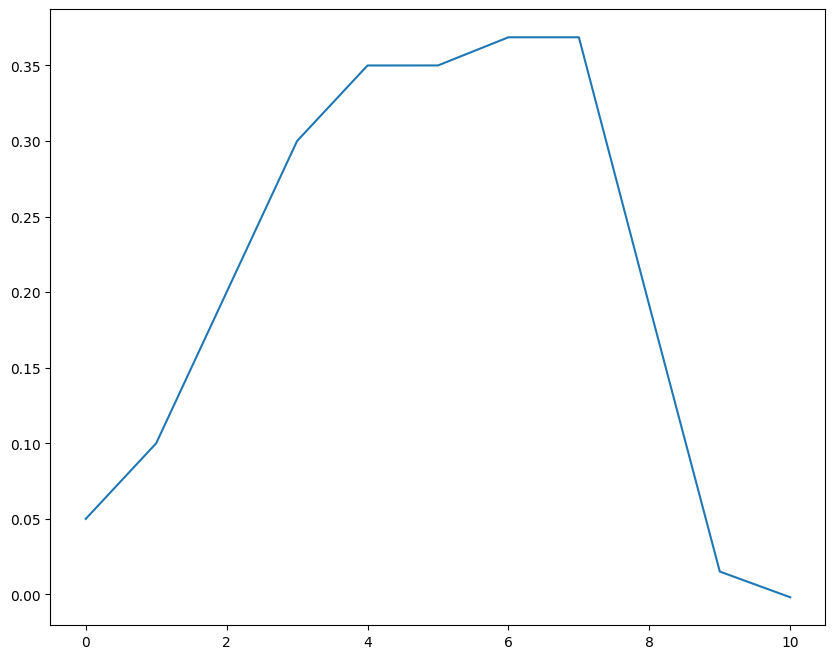

In [186]:
T = map_T(psi, c_name, Y, X, axis=0, C=c.T)

fig, axs = plt.subplots(1, 1, figsize=(10,8))
axs.plot(T)

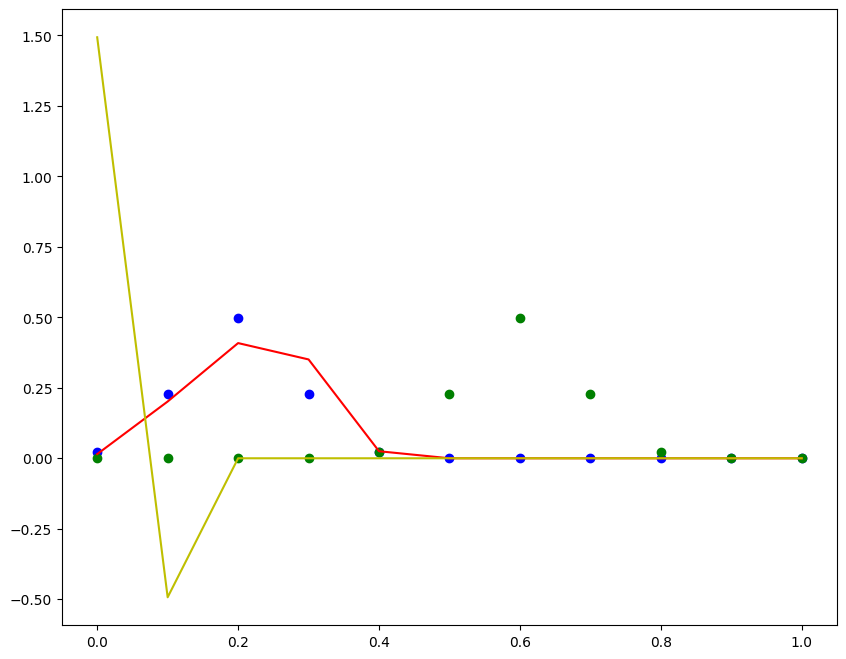

In [189]:
rho1 = pushforward(
        pdf1,
        map_T(psi, c_name, X, Y, axis=0, C=c),
        x
    )

rho2 = pushforward(
        pdf1,
        map_T(phi, c_name, Y, X, axis=0, C=c.T),
        y
    )

fig, axs = plt.subplots(1, 1, figsize=(10,8))
axs.plot(grid2, rho1, 'r')
axs.plot(grid2, rho2, 'y')
axs.scatter(grid1, pdf1, c='b')
axs.scatter(grid2, pdf2, c='g')

# 2-D Examples

Text(0.5, 1.0, 'Distribution $\\nu$')

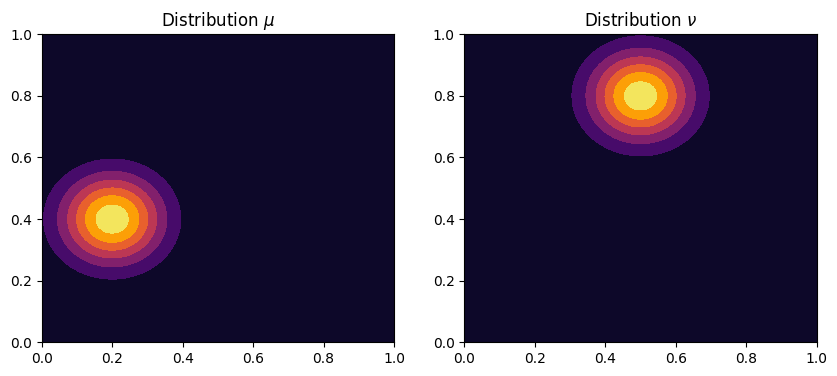

In [ ]:
def generate_2d_gaussian(mean_x, mean_y, sigma_x, sigma_y, range_min, range_max, size=100):
    x = np.linspace(range_min, range_max, size)
    y = np.linspace(range_min, range_max, size)
    x, y = np.meshgrid(x, y)
    z = np.exp(-((x - mean_x)**2 / (2 * sigma_x**2) + (y - mean_y)**2 / (2 * sigma_y**2)))
    
    return x, y, z


range_min = 0
range_max = 1
x1, y1, mu = generate_2d_gaussian(
    mean_x = 0.2,
    mean_y = 0.4,
    sigma_x = 0.1,
    sigma_y = 0.1,
    range_min=range_min,
    range_max=range_max,
    size=100,
    )
x2, y2, nu = generate_2d_gaussian(
    mean_x = 0.5,
    mean_y = 0.8,
    sigma_x = 0.1,
    sigma_y = 0.1,
    range_min=range_min,
    range_max=range_max,
    size=100,
    )

# Plot these distributions
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].contourf(x1, y1, mu, cmap='inferno')
axs[1].contourf(x2, y2, nu, cmap='inferno')
axs[0].set_title('Distribution $\mu$')
axs[1].set_title('Distribution $\\nu$')